<a href="https://colab.research.google.com/github/bardagan/logo_classifier/blob/master/flickr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Connect to Google **Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Getting and converting the data

In [0]:
path = '/content/drive/My Drive/data/flickr_logos_27_dataset'

In [11]:
path_images = path + "/flickr_logos_27_dataset_images"
path_images

'/content/drive/My Drive/data/flickr_logos_27_dataset/flickr_logos_27_dataset_images'

In [16]:
cal = np.genfromtxt(path +'/flickr_logos_27_dataset_training_set_annotation.txt', dtype='str'); cal

array([['144503924.jpg', 'Adidas', '1', '38', '12', '234', '142'],
       ['2451569770.jpg', 'Adidas', '1', '242', '208', '413', '331'],
       ['390321909.jpg', 'Adidas', '1', '13', '5', '89', '60'],
       ['4761260517.jpg', 'Adidas', '1', '43', '122', '358', '354'],
       ...,
       ['217288720.jpg', 'Yahoo', '6', '136', '161', '304', '222'],
       ['2472817996.jpg', 'Yahoo', '6', '2', '4', '499', '106'],
       ['2514220918.jpg', 'Yahoo', '6', '1', '69', '342', '157'],
       ['386891249.jpg', 'Yahoo', '6', '156', '10', '310', '49']], dtype='<U14')

In [0]:
data_points = {}
for point in cal:
  data_points[point[0]] = np.genfromtxt(point[2:])
data_points

In [0]:
fname = '1690276845.jpg' #example

In [0]:
# def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

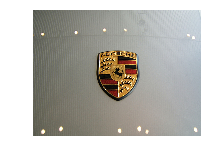

In [37]:
img = open_image(path_images + '/' + fname)
img.show()

In [0]:
# ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = data_points[f]
    return tensor(ctr[2],ctr[1])
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [58]:
get_ctr(fname)

tensor([113., 181.])

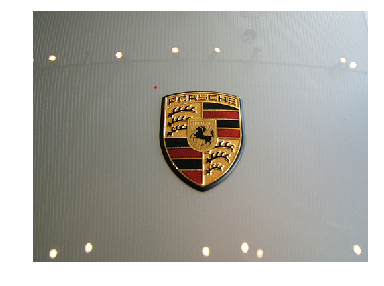

In [60]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

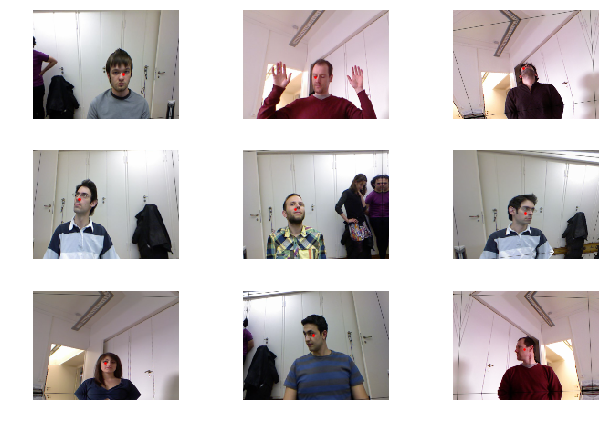

In [0]:
data.show_batch(3, figsize=(9,6))

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


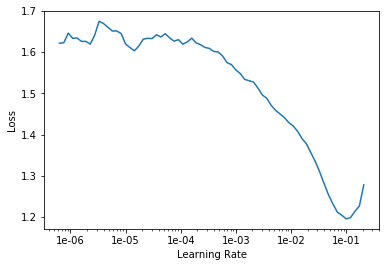

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.052076,0.003733
2,0.018467,0.002182
3,0.009045,0.011063
4,0.005409,0.002293
5,0.004046,0.002766


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

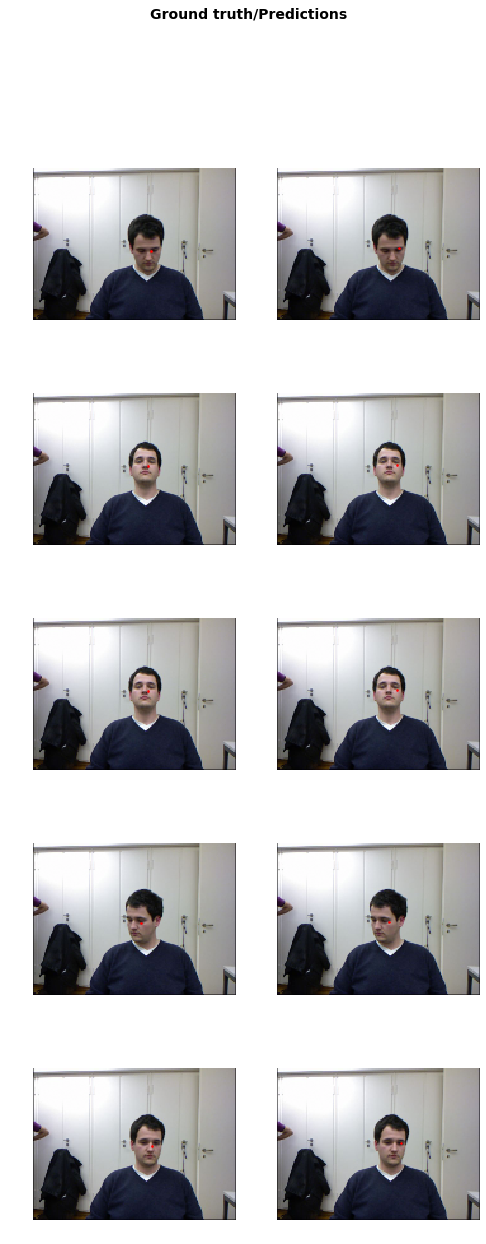

In [0]:
learn.show_results()

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

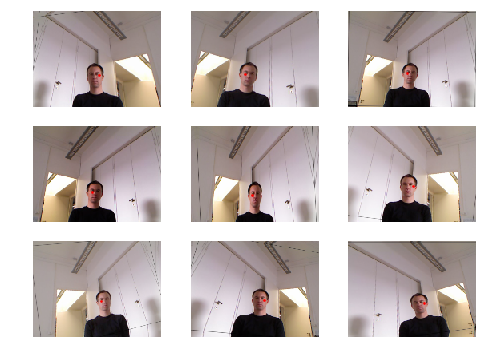

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))